In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('vocab', '/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt', 'vocabulary file')

import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import text2ids

try:
    import conf  
    from conf import TEXT_MAX_WORDS, INPUT_TEXT_MAX_WORDS
except Exception:
    TEXT_MAX_WORDS = 20
    INPUT_TEXT_MAX_WORDS = 20
    
decode_max_words = 10

tensorflow_version: 1.2.0-rc0


In [3]:
def _text2ids(text, max_words):
  word_ids = text2ids.text2ids(text, 
                               seg_method='basic', 
                               feed_single=True, 
                               allow_all_zero=True, 
                               pad=False)
  #word_ids.append(text2ids.vocab.end_id())
  word_ids = word_ids[:max_words]
  word_ids = gezi.pad(word_ids, max_words, 0)

  return word_ids

In [4]:
from libgezi import utf82gbk, gbk2utf8
def predict(predictor, input_text, num_show=1):
  input_text = utf82gbk(input_text)
  word_ids = _text2ids(input_text, INPUT_TEXT_MAX_WORDS)
  print('word_ids', word_ids, 'len:', len(word_ids))
  print(gbk2utf8(text2ids.ids2text(word_ids)))

  timer = gezi.Timer()
  init_states = predictor.inference([
                                        'beam_search_beam_size',
                                        'beam_search_initial_state', 
                                        'beam_search_initial_ids', 
                                        'beam_search_initial_logprobs',
                                        'beam_search_initial_alignments'
                                        ], 
                                        feed_dict= {
                                          tf.get_collection('input_text_feed')[0] : [word_ids]
                                        })

  step_func = lambda input_feed, state_feed : predictor.inference([
                                        'beam_search_state', 
                                        'beam_search_ids', 
                                        'beam_search_logprobs',
                                        'beam_search_alignments', 
                                        ], 
                                        feed_dict= {
                                          #TODO...attetion still need input_text feed, see rnn_decoder.py  beam_search_step
                                          #but not hurt perfomance much because encoder is fast? Is it possible to avoid this?
                                          #anyway if no attention  will not need input_text_feed
                                          tf.get_collection('input_text_feed')[0] : [word_ids],
                                          tf.get_collection('beam_search_input_feed')[0] : input_feed,
                                          tf.get_collection('beam_search_state_feed')[0] : state_feed
                                        })

  max_words = decode_max_words if decode_max_words else TEXT_MAX_WORDS
  beams = melt.seq2seq.beam_search(init_states, 
                                   step_func, 
                                   end_id=text2ids.end_id(), 
                                   max_words=max_words, 
                                   length_normalization_factor=0.)

  #print(len(beams))
  #x_labels = [gbk2utf8(text2ids.vocab.key(x)).encode('utf8') for x in word_ids]
  for i, beam in enumerate(beams):
    if i == num_show:
      break
    print(gbk2utf8(text2ids.ids2text(word_ids)))
    print(i, beam.words, gbk2utf8(text2ids.ids2text(beam.words)), math.exp(beam.logprob), beam.logprob, beam.score, beam.logprobs)
    #print(beam.alignments_list)

    #plt.matshow(beam.alignments_list)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(beam.alignments_list, interpolation='nearest')
    #fig.colorbar(cax)

    #ax.set_xticklabels(['']+x_labels)
    #ax.set_yticklabels(['']+alpha)

    plt.show()


  print('beam search using time(ms):', timer.elapsed_ms())

In [5]:
print(FLAGS.vocab)

/home/gezi/temp/textsum/tfrecord/seq-basic/train/vocab.txt


In [6]:
text2ids.init(FLAGS.vocab)
#model_dir='/home/gezi/temp/textsum/model.seq2seq.attention.encode_end/'
model_dir='/home/gezi/new/temp/textsum/model.seq2seq.copy.ba'
predictor = melt.Predictor(model_dir)

def inference(text, num_show=1):
  predict(predictor, text, num_show=num_show)

ENCODE_UNK 1
restore from /home/gezi/new/temp/textsum/model.seq2seq.copy.ba/model.ckpt-5.7-476000


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/textsum/model.seq2seq.copy.ba/model.ckpt-5.7-476000


import graph ok /home/gezi/new/temp/textsum/model.seq2seq.copy.ba/model.ckpt-5.7-476000.meta
restore ok /home/gezi/new/temp/textsum/model.seq2seq.copy.ba/model.ckpt-5.7-476000


In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

word_ids [5143, 5088, 7316, 532, 13, 691, 742, 805, 5143, 5088, 7316, 532, 13, 11810, 16506, 0, 0, 0, 0, 0] len: 20
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
大棚/辣椒/果实/变/小/怎么/办/,/大棚/辣椒/果实/变/小/防治/措施
0 [5143, 5088, 1] 大棚/辣椒/<EOS> 0.0251734035006 -3.68197 -3.68197 [-0.91694093, -0.82739675, -1.9376296]


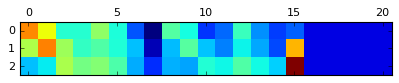

beam search using time(ms): 784.167051315
word_ids [214, 899, 322, 1866, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
你/去/打/篮球/吗
你/去/打/篮球/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0274869686236 -3.59404 -3.59404 [-1.5032948, -0.039664518, -2.0510838]


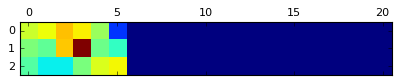

beam search using time(ms): 217.249155045
word_ids [322, 1866, 214, 899, 949, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/你/去/吗
打/篮球/你/去/吗
0 [322, 1866, 1] 打/篮球/<EOS> 0.0226874468843 -3.78594 -3.78594 [-1.1274979, -0.032141354, -2.6263041]


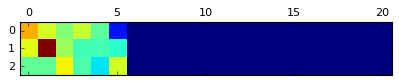

beam search using time(ms): 188.332080841
word_ids [1492, 210, 267, 244, 655, 8, 22731, 80, 40621, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
这/是/周/华/健/的/新歌/爱/相随
这/是/周/华/健/的/新歌/爱/相随
0 [267, 244, 655, 1] 周/华/健/<EOS> 0.0664685463701 -2.71103 -2.71103 [-0.77457184, -0.027568314, -0.016017571, -1.8928688]


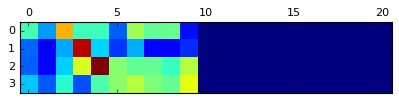

beam search using time(ms): 206.829071045
word_ids [25394, 84, 2743, 19, 807, 752, 805, 31304, 3123, 84, 2102, 1804, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
年少/不/懂/高/晓/松/,/读懂/已/不/再/少年
0 [25394, 84, 2743, 1] 年少/不/懂/<EOS> 0.00684502028889 -4.98423 -4.98423 [-2.6306081, -0.25846574, -0.43795359, -1.6572068]


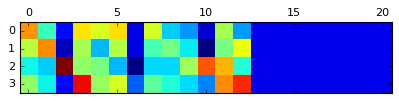

beam search using time(ms): 195.472955704
word_ids [60, 811, 2742, 235, 949, 3383, 60, 811, 2742, 2841, 1679, 57, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
王/凯/整容/了/吗/_/王/凯/整容/前后/对比/照片
0 [60, 811, 2742, 1] 王/凯/整容/<EOS> 0.0124016415315 -4.38993 -4.38993 [-1.1622047, -0.00010787859, -0.96741396, -2.2601998]


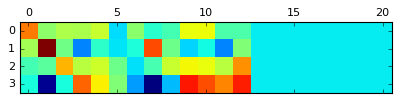

beam search using time(ms): 225.569963455
word_ids [6423, 1083, 5327, 226, 24332, 668, 668, 163, 13, 4073, 62, 107, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
【/贴图/】/韩/敏英/-/-/性感/小/吊带/黑/丝
0 [226, 24332, 1] 韩/敏英/<EOS> 0.0256034397297 -3.66503 -3.66503 [-1.0254762, -0.032953825, -2.6065986]


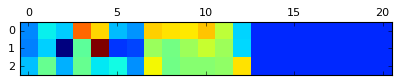

beam search using time(ms): 196.771144867
word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0283899820508 -3.56172 -3.56172 [-1.2888601, -0.29330108, -1.9795576]


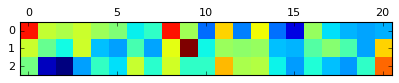

beam search using time(ms): 192.151784897
word_ids [37, 14356, 7, 16948, 1513, 1481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
美女/劈叉/ /鼻血/狂/喷
美女/劈叉/ /鼻血/狂/喷
0 [37, 14356, 1] 美女/劈叉/<EOS> 0.0514362800429 -2.96741 -2.96741 [-1.4247324, -0.695858, -0.84682107]


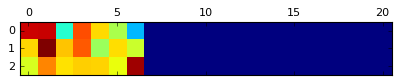

beam search using time(ms): 206.31313324
word_ids [1817, 7, 1252, 228, 7, 4006, 228, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
》/ /卫生/间/ /洗手/间/ 
》/ /卫生/间/ /洗手/间/ 
0 [1252, 228, 1] 卫生/间/<EOS> 0.0201030695246 -3.90688 -3.90688 [-1.3024224, 0.0, -2.6044602]


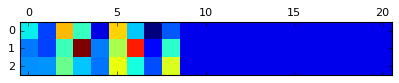

beam search using time(ms): 204.082965851
word_ids [2234, 7, 3885, 4193, 828, 146, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
iphone/ /6s/耐克/主题/手机/壁纸
iphone/ /6s/耐克/主题/手机/壁纸
0 [4193, 30, 1] 耐克/壁纸/<EOS> 0.0579402820509 -2.84834 -2.84834 [-1.4763385, -0.56533337, -0.80667061]


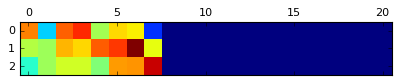

beam search using time(ms): 205.105066299


In [8]:
predict(predictor, "大棚辣椒果实变小怎么办,大棚辣椒果实变小防治措施")
predict(predictor, '你去打篮球吗')
predict(predictor, '打篮球你去吗')
predict(predictor, '这是周华健的新歌爱相随')
inference('年少不懂高晓松,读懂已不再少年')
inference('王凯整容了吗_王凯整容前后对比照片')
inference('【贴图】韩敏英--性感小吊带黑丝')
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看')
inference('美女劈叉 鼻血狂喷')
inference('》 卫生间 洗手间 ')
inference('iphone 6s耐克主题手机壁纸')

word_ids [8246, 9974, 1298, 426, 775, 448, 2238, 1800, 88, 2340, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
蜀山/战纪/赵丽/颖/古装/剧照/(/12/张/)/ 
0 [1298, 426, 775, 448, 1] 赵丽/颖/古装/剧照/<EOS> 0.0623468247813 -2.77504 -2.77504 [-0.73462641, -0.0042568315, -1.3291146, -0.441181, -0.26586369]


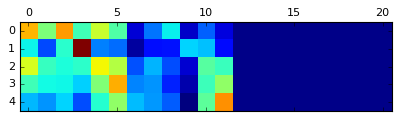

beam search using time(ms): 210.005998611


In [9]:
inference('蜀山战纪赵丽颖古装剧照(12张) ')

word_ids [323, 56, 758, 45, 301, 9147, 1733, 410, 570, 1100, 8, 6091, 1817, 0, 0, 0, 0, 0, 0, 0] len: 20
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
幼儿/园/动物/简/笔画/教案/《/两/条/漂亮/的/小鱼/》
0 [323, 56, 758, 45, 301, 1] 幼儿/园/动物/简/笔画/<EOS> 0.0144211974396 -4.23906 -4.23906 [-0.95732534, -0.030116009, -2.0999036, -0.33017856, -0.10724095, -0.71429175]


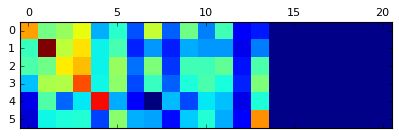

beam search using time(ms): 206.665992737


In [10]:
inference('幼儿园动物简笔画教案《两条漂亮的小鱼》')

word_ids [334, 595, 85, 1034, 11, 5593, 121, 389, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
第/六/感/美甲/美/睫/纹/秀
第/六/感/美甲/美/睫/纹/秀
0 [1034, 1] 美甲/<EOS> 0.00730794822927 -4.91879 -4.91879 [-1.7100174, -3.2087755]


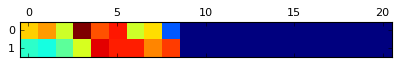

beam search using time(ms): 194.213151932


In [11]:
inference('第六感美甲美睫纹秀')

word_ids [4305, 5762, 3136, 5697, 2060, 389, 1961, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
2013/春夏/男装/米兰/时装/秀/9
2013/春夏/男装/米兰/时装/秀/9
0 [5697, 2060, 389, 1] 米兰/时装/秀/<EOS> 0.0109562787776 -4.51384 -4.51384 [-2.8105345, -1.0789545, -0.21840671, -0.40594652]


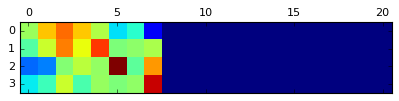

beam search using time(ms): 226.48692131


In [12]:
inference('2013春夏男装米兰时装秀9')

word_ids [772, 7630, 67, 89652, 8, 19841, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
关于/房价/最/透彻/的/解读
关于/房价/最/透彻/的/解读
0 [7630, 1] 房价/<EOS> 0.0216111560823 -3.83455 -3.83455 [-1.7575983, -2.0769472]


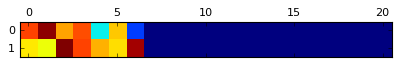

beam search using time(ms): 184.932947159


In [13]:
inference('关于房价最透彻的解读')

word_ids [4667, 630, 7902, 51, 1297, 10515, 4961, 7170, 16504, 3467, 25032, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
辽宁/省/中小/学/教师/职称/制度/改革/实施/方案/出台
0 [1297, 10515, 4961, 1] 教师/职称/制度/<EOS> 0.0492553200457 -3.01074 -3.01074 [-1.579828, -0.088296533, -1.009394, -0.33321941]


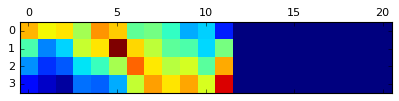

beam search using time(ms): 185.393095016


In [14]:
inference('辽宁省中小学教师职称制度改革实施方案出台')

word_ids [4470, 452, 208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
骷髅/情侣/纹身
骷髅/情侣/纹身
0 [4470, 452, 208, 1] 骷髅/情侣/纹身/<EOS> 0.0317468837325 -3.44996 -3.44996 [-1.2695369, -1.268743, -0.38455194, -0.52712858]


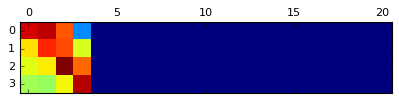

beam search using time(ms): 193.158149719


In [15]:
inference('骷髅情侣纹身')

word_ids [42999, 869, 1474, 363, 8, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/朴/姬/兰/的/刘/亦/菲
酷似/朴/姬/兰/的/刘/亦/菲
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0129413062664 -4.34733 -4.34733 [-0.83016735, -0.25982994, -1.0143523, -2.2429817]


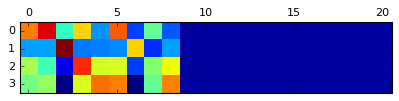

酷似/朴/姬/兰/的/刘/亦/菲
1 [869, 1474, 1] 朴/姬/<EOS> 0.00597453912687 -5.12025 -5.12025 [-0.83016735, -0.25982994, -4.030251]


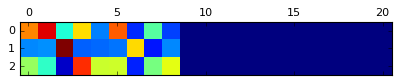

beam search using time(ms): 297.008991241


In [16]:
inference('酷似朴姬兰的刘亦菲', 2)

word_ids [42999, 164, 926, 649, 8, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
酷似/刘/亦/菲/的/朴/姬/兰
酷似/刘/亦/菲/的/朴/姬/兰
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.028293556837 -3.56512 -3.56512 [-0.80068332, -0.34331453, -1.641381, -0.77974218]


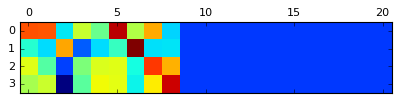

酷似/刘/亦/菲/的/朴/姬/兰
1 [869, 1474, 1] 朴/姬/<EOS> 0.0086544803299 -4.74968 -4.74968 [-0.80068332, -0.34331453, -3.6056802]


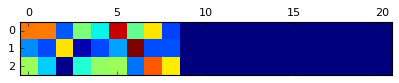

酷似/刘/亦/菲/的/朴/姬/兰
2 [363, 1] 兰/<EOS> 0.00171930655329 -6.36583 -6.36583 [-4.1247764, -2.2410579]


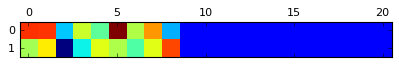

酷似/刘/亦/菲/的/朴/姬/兰
3 [164, 926, 649, 363, 1] 刘/亦/菲/兰/<EOS> 0.000573810943437 -7.46321 -7.46321 [-2.7201254, -0.023998491, -0.035009351, -4.0374026, -0.64667481]


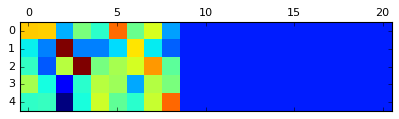

酷似/刘/亦/菲/的/朴/姬/兰
4 [42999, 164, 926, 649, 1] 酷似/刘/亦/菲/<EOS> 0.000481174849049 -7.63928 -7.63928 [-2.6906445, -2.1872709, -0.046386357, -0.054734468, -2.6602435]


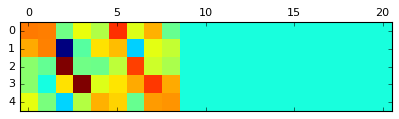

beam search using time(ms): 527.356863022


In [17]:
inference('酷似刘亦菲的朴姬兰', 5)

word_ids [97, 80, 322, 1866, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
我/爱/打/篮球
我/爱/打/篮球
0 [322, 1866, 1] 打/篮球/<EOS> 0.0242353943179 -3.71994 -3.71994 [-1.9432418, -0.038269185, -1.73843]


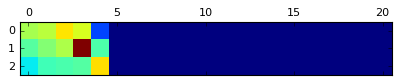

beam search using time(ms): 278.177022934


In [18]:
inference('我爱打篮球')

word_ids [322, 1866, 181, 84, 181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
打/篮球/好/不/好
打/篮球/好/不/好
0 [322, 1866, 1] 打/篮球/<EOS> 0.00591009705692 -5.13109 -5.13109 [-2.0408778, -0.058973178, -3.0312421]


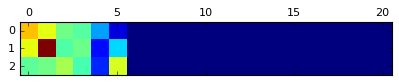

beam search using time(ms): 227.324962616


In [19]:
inference('打篮球好不好')

word_ids [27135, 7, 1614, 6577, 8, 157, 10898, 21077, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
0 [27135, 1] 厄瓜多尔/<EOS> 0.00949340079624 -4.65716 -4.65716 [-1.1511254, -3.5060329]


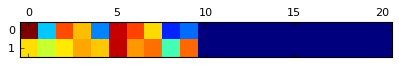

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
1 [27135, 157, 10898, 1] 厄瓜多尔/南/美洲/<EOS> 0.00776565382541 -4.85804 -4.85804 [-1.1511254, -1.9513674, -0.097851224, -1.6577005]


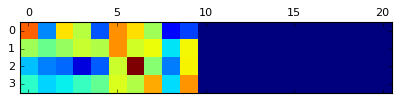

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
2 [157, 10898, 1] 南/美洲/<EOS> 0.00638414368533 -5.05394 -5.05394 [-1.884253, -0.036726438, -3.1329584]


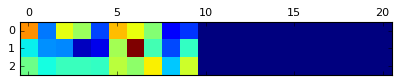

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
3 [157, 10898, 21077, 1] 南/美洲/国度/<EOS> 0.00624280663442 -5.07633 -5.07633 [-1.884253, -0.036726438, -2.3279963, -0.82734984]


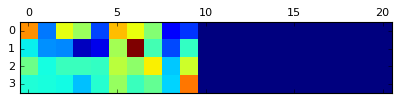

厄瓜多尔/ /美丽/神秘/的/南/美洲/国度/ 
4 [27135, 21077, 1] 厄瓜多尔/国度/<EOS> 0.00466339982379 -5.36801 -5.36801 [-1.1511254, -3.5844698, -0.63241524]


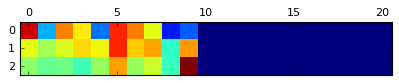

beam search using time(ms): 592.486143112


In [20]:
inference('厄瓜多尔 美丽神秘的南美洲国度 ', 5)

word_ids [1672, 485, 3243, 533, 392, 5154, 8, 1733, 16400, 670, 1817, 36325, 7, 1311, 148, 7, 31396, 213, 1343, 872] len: 20
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
0 [16400, 670, 1] 寒战/2/<EOS> 0.0283899685134 -3.56172 -3.56172 [-1.2888597, -0.29330221, -1.9795574]


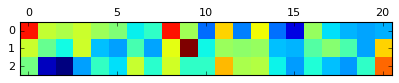

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
1 [1672, 485, 3243, 16400, 670, 1] 彭/于/晏/寒战/2/<EOS> 0.0046645518335 -5.36776 -5.36776 [-1.2904161, -0.0042361766, -0.0015373328, -2.3814287, -0.66968918, -1.020456]


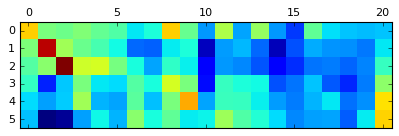

彭/于/晏/都/力/荐/的/《/寒战/2/》/imax/ /3d/版/ /华龙/网/送/票
2 [1672, 485, 3243, 16400, 1] 彭/于/晏/寒战/<EOS> 0.00366093619557 -5.61004 -5.61004 [-1.2904161, -0.0042361766, -0.0015373328, -2.3814287, -1.9324179]


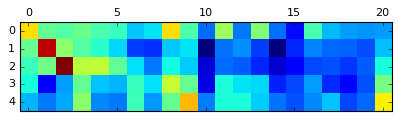

beam search using time(ms): 378.403186798


In [21]:
inference('彭于晏都力荐的《寒战2》imax 3d版 华龙网送票邀你提前看', 3)

word_ids [84, 210, 869, 1474, 363, 210, 164, 926, 649, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
不/是/朴/姬/兰/是/刘/亦/菲
不/是/朴/姬/兰/是/刘/亦/菲
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.0238582031218 -3.73563 -3.73563 [-1.0085828, -0.15279871, -0.92317855, -1.6510673]


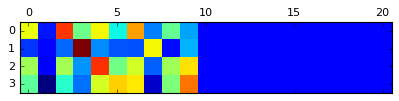

不/是/朴/姬/兰/是/刘/亦/菲
1 [869, 1474, 1] 朴/姬/<EOS> 0.0074970426413 -4.89325 -4.89325 [-1.0085828, -0.15279871, -3.7318649]


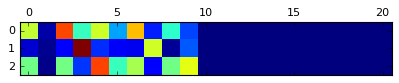

不/是/朴/姬/兰/是/刘/亦/菲
2 [869, 1474, 363, 164, 926, 649, 1] 朴/姬/兰/刘/亦/菲/<EOS> 0.00140168554831 -6.57008 -6.57008 [-1.0085828, -0.15279871, -0.92317855, -3.5193448, -0.015438337, -0.040628992, -0.91010761]


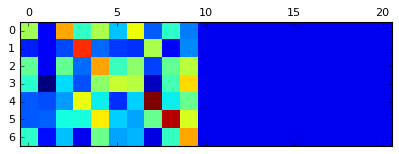

beam search using time(ms): 408.06388855


In [22]:
inference('不是朴姬兰是刘亦菲', 3)

word_ids [84, 210, 164, 926, 649, 210, 869, 1474, 363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20
不/是/刘/亦/菲/是/朴/姬/兰
不/是/刘/亦/菲/是/朴/姬/兰
0 [869, 1474, 363, 1] 朴/姬/兰/<EOS> 0.020993126597 -3.86356 -3.86356 [-1.1760377, -0.48650599, -1.4483902, -0.75262642]


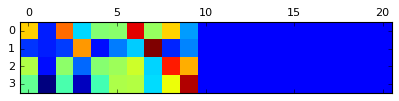

不/是/刘/亦/菲/是/朴/姬/兰
1 [869, 1474, 1] 朴/姬/<EOS> 0.00528821372007 -5.24227 -5.24227 [-1.1760377, -0.48650599, -3.5797312]


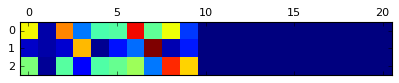

不/是/刘/亦/菲/是/朴/姬/兰
2 [363, 1] 兰/<EOS> 0.00151937360592 -6.48946 -6.48946 [-4.3227553, -2.166702]


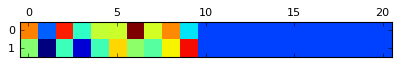

beam search using time(ms): 378.807067871


In [ ]:
inference('不是刘亦菲是朴姬兰', 3)

word_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len: 20


0 [4, 1] 图/<EOS> 1.9151843897e-07 -15.4683 -15.4683 [-11.513011, -3.955271]


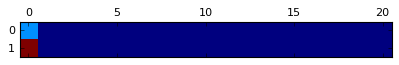


1 [3, 1] <S>/<EOS> 1.89382338639e-07 -15.4795 -15.4795 [-11.513011, -3.9664869]


In [ ]:
inference('', 3)